# Read Dataset

In [2]:
import pandas as pd

df = pd.read_csv('../data/color_names_all.csv')
df

,name,red,green,blue
0,100 Mph,201,63,56
1,18Th Century Green,165,147,68
2,1975 Earth Red,123,70,59
3,1989 Miami Hotline,221,51,102
4,20000 Leagues Under The Sea,25,25,112
...,...,...,...,...
31147,Über Umber,123,88,56
31148,Āsmānī Sky,136,221,187
31149,Ōkaihau Express,205,70,0
31150,Ōtan Red,255,78,32


In [3]:
names = df['name']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31152 entries, 0 to 31151
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    31152 non-null  object
 1   red     31152 non-null  int64 
 2   green   31152 non-null  int64 
 3   blue    31152 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 973.6+ KB


# Preprocessing Data
## Tokenization

In [5]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import preprocessing


maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)

2024-08-13 12:29:14.541867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/sol/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
padded_names.shape

(31152, 25)

## One-hot encoding

In [7]:
from keras.utils import to_categorical
one_hot_names = to_categorical(padded_names)


In [8]:
one_hot_names.shape

(31152, 25, 95)

In [9]:
one_hot_names[0]


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Normalization

In [10]:
import numpy as np
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(df["red"]), norm(df["green"]), norm(df["blue"])])

In [11]:
normalized_values.shape

(31152, 3)

In [12]:
normalized_values[0]

array([0.78823529, 0.24705882, 0.21960784])

## Split Data

In [13]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(one_hot_names, normalized_values, test_size=0.2, random_state=17)




# Create model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, 95)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 25, 256)        │       360,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,467 (2.19 MB)

 Trainable params: 574,467 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

## Fit Model

In [19]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 83s 110ms/step - acc: 0.5823 - loss: 0.0673 - val_acc: 0.6037 - val_loss: 0.0619
Epoch 2/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 74s 105ms/step - acc: 0.6325 - loss: 0.0603 - val_acc: 0.5921 - val_loss: 0.0576
Epoch 3/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 73s 104ms/step - acc: 0.6457 - loss: 0.0552 - val_acc: 0.6362 - val_loss: 0.0545
Epoch 4/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - acc: 0.6501 - loss: 0.0528 - val_acc: 0.6450 - val_loss: 0.0528
Epoch 5/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - acc: 0.6606 - loss: 0.0504 - val_acc: 0.6294 - val_loss: 0.0516
Epoch 6/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - acc: 0.6579 - loss: 0.0486 - val_acc: 0.6394 - val_loss: 0.0509
Epoch 7/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - acc: 0.6665 - loss: 0.0466 - val_acc: 0.6454 - val_loss: 0.0495
Epoch 8/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - acc: 0.6699 - loss: 0.0436 - val_acc: 0.6518 - val_loss: 0.0494
Epoch 9/20
701/701 ━━━━━━━━━━━━━━━━

In [ ]:
#save model
import pickle

history.save('color_model.h5')
# save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)
    



In [22]:
history.history.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

## Metrics


In [20]:
# The validation accuracy and loss are already included in the history
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_acc'][-1]

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

Validation Loss: 0.05795558542013168
Validation Accuracy: 0.6337745785713196


In [21]:
#on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.6471 - loss: 0.0598
Test Loss: 0.05886062607169151
Test Accuracy: 0.6443588733673096


### Clasification Report and CM

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Confusion Matrix:
 [[2664  554  362]
 [ 440  651  181]
 [ 415  264  700]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75      3580
           1       0.44      0.51      0.48      1272
           2       0.56      0.51      0.53      1379

    accuracy                           0.64      6231
   macro avg       0.59      0.59      0.59      6231
weighted avg       0.65      0.64      0.65      6231



### Confusion Matrix

In [23]:
import plotly.express as px
labels = ['red', 'green', 'blue']
fig = px.imshow(cm, text_auto=True,labels=dict(x="Predicted", y="True", color="Count"))
fig.update_xaxes(tickvals=[0, 1, 2], ticktext=labels)
fig.update_yaxes(tickvals=[0, 1, 2], ticktext=labels)
fig.show()

### Learning Curve

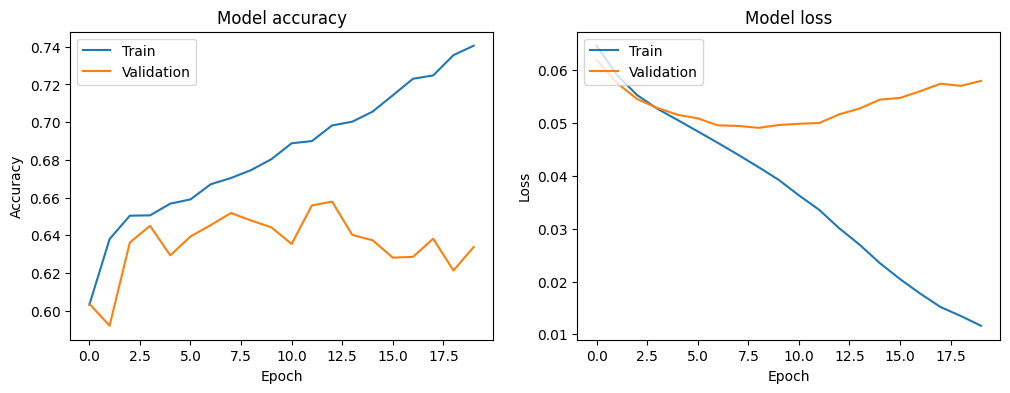

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Calibration Curve

In [26]:
# Predict the probabilities
y_pred_probs = model.predict(X_test)

# If you have multi-class output, you can use argmax to get the class with the highest probability
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# For the true labels
y_true_classes = np.argmax(y_test, axis=1)

# Display some predictions vs true labels
print("Predicted classes: ", y_pred_classes[:10])
print("True classes: ", y_true_classes[:10])


195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Predicted classes:  [0 0 0 0 1 0 0 0 0 0]
True classes:  [0 2 1 0 2 0 0 0 0 0]


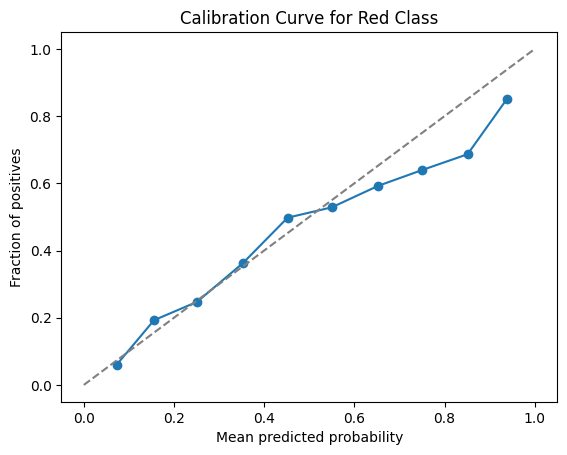

In [27]:
from sklearn.calibration import calibration_curve

# Assuming you want the calibration curve for the first class (e.g., 'Red')
prob_true, prob_pred = calibration_curve(y_true_classes == 0, y_pred_probs[:, 0], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Calibration Curve for Red Class')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.show()


## Validation

#### Cross-validation

In [29]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score

def create_model():
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, 95)))
    model.add(LSTM(128))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

# Wrap the model with KerasREgressor
model = KerasRegressor(model=create_model, epochs=40, batch_size=32, verbose=1)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1)
print(f'Cross-validation scores: {scores}')
print(f'Average cross-validation score: {np.mean(scores)}')


/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - acc: 0.5374 - loss: 0.0806
Epoch 2/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - acc: 0.5826 - loss: 0.0724
Epoch 3/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - acc: 0.6410 - loss: 0.0657
Epoch 4/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - acc: 0.6396 - loss: 0.0642
Epoch 5/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - acc: 0.6340 - loss: 0.0632
Epoch 6/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - acc: 0.6413 - loss: 0.0642
Epoch 7/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - acc: 0.6547 - loss: 0.0607
Epoch 8/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - acc: 0.6653 - loss: 0.0579
Epoch 9/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - acc: 0.6569 - loss: 0.0579
Epoch 10/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - acc: 0.6600 - loss: 0.0559
Epoch 11/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - acc: 0.6315 - loss: 0.0536
Epoch 12/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - acc: 0.6709 - lo

/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - acc: 0.5467 - loss: 0.0831
Epoch 2/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - acc: 0.6223 - loss: 0.0723
Epoch 3/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - acc: 0.6468 - loss: 0.0711
Epoch 4/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - acc: 0.6459 - loss: 0.0700
Epoch 5/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - acc: 0.6678 - loss: 0.0663
Epoch 6/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - acc: 0.6686 - loss: 0.0659
Epoch 7/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - acc: 0.6635 - loss: 0.0641
Epoch 8/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - acc: 0.6744 - loss: 0.0627
Epoch 9/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - acc: 0.6770 - loss: 0.0610
Epoch 10/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - acc: 0.6624 - loss: 0.0595
Epoch 11/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - acc: 0.6779 - loss: 0.0600
Epoch 12/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - acc: 0.6952 - lo

/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - acc: 0.4829 - loss: 0.0808
Epoch 2/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - acc: 0.5798 - loss: 0.0736
Epoch 3/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - acc: 0.5885 - loss: 0.0708
Epoch 4/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - acc: 0.6177 - loss: 0.0679
Epoch 5/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - acc: 0.6181 - loss: 0.0672
Epoch 6/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - acc: 0.6447 - loss: 0.0658
Epoch 7/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - acc: 0.6455 - loss: 0.0618
Epoch 8/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - acc: 0.6678 - loss: 0.0614
Epoch 9/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - acc: 0.6631 - loss: 0.0619
Epoch 10/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - acc: 0.6528 - loss: 0.0582
Epoch 11/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - acc: 0.6842 - loss: 0.0571
Epoch 12/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - acc: 0.6583 - loss: 0.0566


## Hyperparameters tunning

### GridSearch

In [29]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the function that creates the model
def create_model(lstm_units_1=256, lstm_units_2=128, dense_units=128, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(lstm_units_1, return_sequences=True, input_shape=(maxlen, 95)))
    model.add(LSTM(lstm_units_2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasREgressor
model = KerasRegressor(model=create_model, epochs=40, batch_size=32, verbose=1)

# Define the parameter grid to search over
param_grid = {
    'model__lstm_units_1': [128, 256],        # Number of units in the first LSTM layer
    'model__lstm_units_2': [64, 128],         # Number of units in the second LSTM layer
    'model__dense_units': [64, 128],          # Number of units in the dense layer
    'batch_size': [16, 32],                   # Batch size for training
    'epochs': [20, 40],                       # Number of epochs for training
    'model__learning_rate': [0.001, 0.01]     # Learning rate for the optimizer
}

# Set up the GridSearchCV with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Perform the grid search
grid_result = grid.fit(X_train, y_train)

# Display the best parameters and best score
print(f'Best parameters found: {grid_result.best_params_}')
print(f'Best cross-validation score: {grid_result.best_score_}')


Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarni

Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 146s 132ms/step - accuracy: 0.5059 - loss: 1.9936
1024/1039 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.2173 - loss: 1.98913Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 145s 132ms/step - accuracy: 0.3103 - loss: 1.9528
 670/1039 ━━━━━━━━━━━━━━━━━━━━ 1:15 203ms/step - accuracy: 0.4365 - loss: 1.9646Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 147s 134ms/step - accuracy: 0.2177 - loss: 1.9889
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 177s 163ms/step - accuracy: 0.4125 - loss: 1.9673
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 179s 164ms/step - accuracy: 0.2246 - loss: 1.9743
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 179s 166ms/step - accuracy: 0.5126 - loss: 1.9790
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 223s 207ms/step - accuracy: 0.5345 - loss: 1.9553
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 224s 208ms/step - accuracy: 0.4138

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 700/1039 ━━━━━━━━━━━━━━━━━━━━ 1:25 253ms/step - accuracy: 0.3668 - loss: 9.0240

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 184s 177ms/step - accuracy: 0.3493 - loss: 21.5291
 764/1039 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.3493 - loss: 4.6218Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 154s 147ms/step - accuracy: 0.3499 - loss: 6.6233
 653/1039 ━━━━━━━━━━━━━━━━━━━━ 1:34 246ms/step - accuracy: 0.3404 - loss: 11.5778Epoch 1/20
 817/1039 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.3493 - loss: 4.6416Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 215s 207ms/step - accuracy: 0.3495 - loss: 4.7039
Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 216s 208ms/step - accuracy: 0.3564 - loss: 3.5352
 883/1039 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.3419 - loss: 11.7541Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 252s 242ms/step - accuracy: 0.3494 - loss: 10.2509
Epoch 13/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 213s 205ms/step - accuracy: 0.3478 - loss: 5.3301
Epoch 15/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/stepracy: 0.4844 - loss: 16.2808  : 23.0606
  65/1039 ━━━━━━━━━━━━━━━━━━━

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 781/1039 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.3532 - loss: 14.4624Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 152s 145ms/step - accuracy: 0.3519 - loss: 14.3799
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 154s 148ms/step - accuracy: 0.3463 - loss: 22.0136
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 170s 149ms/step - accuracy: 0.3400 - loss: 14.4868
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 195s 187ms/step - accuracy: 0.3544 - loss: 6.7217
Epoch 16/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 198s 190ms/step - accuracy: 0.3573 - loss: 3.6843
Epoch 16/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 200s 192ms/step - accuracy: 0.3462 - loss: 6.6005
Epoch 16/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 275s 137ms/step - accuracy: 0.2232 - loss: 1.9510
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 275s 135ms/step - accuracy: 0.2708 - loss: 1.9458
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 233s 224ms/step - accuracy: 0.3461 - loss: 12.1447
Epoch 14/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 226ms/step - accuracy: 0.3589 - lo

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


520/520 ━━━━━━━━━━━━━━━━━━━━ 48s 70ms/stepstep - accuracy: 0.3602 - loss: 12.472
 147/1039 ━━━━━━━━━━━━━━━━━━━━ 3:10 214ms/step - accuracy: 0.3585 - loss: 12.7617Epoch 1/20
 384/1039 ━━━━━━━━━━━━━━━━━━━━ 1:23 127ms/step - accuracy: 0.4137 - loss: 2.0167[CV] END batch_size=16, epochs=20, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=128; total time=65.1min
 658/1039 ━━━━━━━━━━━━━━━━━━━━ 1:15 199ms/step - accuracy: 0.3485 - loss: 8.3563

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 157/1039 ━━━━━━━━━━━━━━━━━━━━ 3:10 216ms/step - accuracy: 0.3661 - loss: 14.0367Epoch 1/20
 926/1039 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3635 - loss: 1.98543

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 219/1039 ━━━━━━━━━━━━━━━━━━━━ 2:56 215ms/step - accuracy: 0.3620 - loss: 14.1085Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 190s 129ms/step - accuracy: 0.3632 - loss: 1.9867
Epoch 4/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 134s 128ms/step - accuracy: 0.3385 - loss: 1.9987
Epoch 4/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 200s 192ms/step - accuracy: 0.3490 - loss: 7.8411
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 126s 121ms/step - accuracy: 0.3975 - loss: 2.0228
Epoch 4/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 198s 190ms/step - accuracy: 0.3526 - loss: 4.2642
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 193s 185ms/step - accuracy: 0.3532 - loss: 7.4970
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 113s 109ms/step - accuracy: 0.3626 - loss: 2.0141
 640/1039 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.3678 - loss: 2.0497Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 200s 192ms/step - accuracy: 0.3468 - loss: 2.0093
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 292s 281ms/step - accuracy: 0.3536 - loss: 16.5352
Epoch 16

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 123s 118ms/step - accuracy: 0.3535 - loss: 2.1952
Epoch 5/20
 669/1039 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.3583 - loss: 2.3388Epoch 1/20
 569/1039 ━━━━━━━━━━━━━━━━━━━━ 1:17 165ms/step - accuracy: 0.3483 - loss: 16.3194

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 932/1039 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.3516 - loss: 2.25579

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  75/1039 ━━━━━━━━━━━━━━━━━━━━ 1:40 104ms/step - accuracy: 0.3349 - loss: 2.2481Epoch 1/20
 905/1039 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.3593 - loss: 2.1643Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 119s 114ms/step - accuracy: 0.3522 - loss: 2.2523260m 20s 85ms/step - accuracy: 0.3589 - loss: 2.31
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 125s 119ms/step - accuracy: 0.3588 - loss: 2.1720
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 98s 94ms/step - accuracy: 0.3589 - loss: 2.29422
Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 102s 98ms/step - accuracy: 0.3599 - loss: 2.1679
Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 105s 101ms/step - accuracy: 0.3623 - loss: 2.5387
 566/1039 ━━━━━━━━━━━━━━━━━━━━ 1:05 138ms/step - accuracy: 0.3412 - loss: 2.3267Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 189s 181ms/step - accuracy: 0.3488 - loss: 16.7400
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 187s 180ms/step - accuracy: 0.3393 - loss: 17.0531
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 188s 181m

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 237/1039 ━━━━━━━━━━━━━━━━━━━━ 1:35 119ms/step - accuracy: 0.3598 - loss: 6.3449[CV] END batch_size=16, epochs=20, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=128; total time=88.4min
 350/1039 ━━━━━━━━━━━━━━━━━━━━ 1:50 160ms/step - accuracy: 0.3923 - loss: 2.0078[CV] END batch_size=16, epochs=20, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=128; total time=88.4min
 585/1039 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.3247 - loss: 4.7174Epoch 1/20
 811/1039 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.3478 - loss: 3.3494

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 112s 107ms/step - accuracy: 0.3507 - loss: 3.1294
Epoch 15/20
 768/1039 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - accuracy: 0.3534 - loss: 6.3658

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 827/1039 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.3538 - loss: 6.2615Epoch 1/20
 767/1039 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.3301 - loss: 4.9064Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 102s 98ms/step - accuracy: 0.3467 - loss: 3.2340
 600/1039 ━━━━━━━━━━━━━━━━━━━━ 1:03 144ms/step - accuracy: 0.3877 - loss: 2.0202Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 126s 121ms/step - accuracy: 0.3542 - loss: 5.9836
Epoch 9/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 97s 93ms/step - accuracy: 0.3354 - loss: 5.0956
Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 107s 102ms/step - accuracy: 0.3593 - loss: 5.4563
Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 136s 130ms/step - accuracy: 0.3841 - loss: 1.9906
  23/1039 ━━━━━━━━━━━━━━━━━━━━ 1:27 86ms/step - accuracy: 0.3443 - loss: 5.6370Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 136s 130ms/step - accuracy: 0.4182 - loss: 2.0067
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 137s 132ms/step - accuracy: 0.3849 - loss: 2.0242
Epoch 5/20
1039/1039 ━━━━━━━━

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 169s 162ms/step - accuracy: 0.3492 - loss: 3.4233
 148/1039 ━━━━━━━━━━━━━━━━━━━━ 8:05 545ms/step - accuracy: 0.3573 - loss: 2.2178Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 228s 219ms/step - accuracy: 0.3544 - loss: 2.2406
Epoch 9/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 226s 217ms/step - accuracy: 0.3679 - loss: 2.1097
 894/1039 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.3432 - loss: 9.0477Epoch 9/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 93s 159ms/steptep - accuracy: 0.3684 - loss: 2.28
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 228s 219ms/step - accuracy: 0.3627 - loss: 2.2226
Epoch 9/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 194s 186ms/step - accuracy: 0.3369 - loss: 10.8834
 227/1039 ━━━━━━━━━━━━━━━━━━━━ 5:42 422ms/step - accuracy: 0.3620 - loss: 2.3752Epoch 15/20
  26/1039 ━━━━━━━━━━━━━━━━━━━━ 2:26 145ms/step - accuracy: 0.3616 - loss: 9.2540[CV] END batch_size=16, epochs=20, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=64; total 

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


520/520 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/stepstep - accuracy: 0.3696 - loss: 2.3682
 387/1039 ━━━━━━━━━━━━━━━━━━━━ 3:32 327ms/step - accuracy: 0.3696 - loss: 2.3677Epoch 1/20
 423/1039 ━━━━━━━━━━━━━━━━━━━━ 3:13 315ms/step - accuracy: 0.3695 - loss: 2.3635[CV] END batch_size=16, epochs=20, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=64; total time=48.2min
 513/1039 ━━━━━━━━━━━━━━━━━━━━ 2:32 291ms/step - accuracy: 0.3690 - loss: 2.3585

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 448/1039 ━━━━━━━━━━━━━━━━━━━━ 1:13 124ms/step - accuracy: 0.3518 - loss: 12.9191Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 242s 232ms/step - accuracy: 0.3595 - loss: 2.3024
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 129s 124ms/step - accuracy: 0.3553 - loss: 13.7233
Epoch 16/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 129s 123ms/step - accuracy: 0.3500 - loss: 11.8473
Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 126s 121ms/step - accuracy: 0.3401 - loss: 11.1279
Epoch 16/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 241s 231ms/step - accuracy: 0.3614 - loss: 2.5153
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 242s 233ms/step - accuracy: 0.3663 - loss: 2.4459
  83/1039 ━━━━━━━━━━━━━━━━━━━━ 2:03 129ms/step - accuracy: 0.3511 - loss: 5.9585Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 157s 151ms/step - accuracy: 0.3430 - loss: 2.1864
Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 157s 151ms/step - accuracy: 0.3627 - loss: 2.4192
Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 157s 151ms/step - accuracy: 0.3617 - loss: 2.3149
Epo

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 843/1039 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.3407 - loss: 5.4294Epoch 1/20
 233/1039 ━━━━━━━━━━━━━━━━━━━━ 2:07 159ms/step - accuracy: 0.3369 - loss: 2.4540

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 250/1039 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - accuracy: 0.3580 - loss: 2.9910Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 115s 110ms/step - accuracy: 0.3425 - loss: 5.4860
Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 210s 202ms/step - accuracy: 0.3473 - loss: 6.3215
 919/1039 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.3502 - loss: 6.8720Epoch 9/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 138s 132ms/step - accuracy: 0.3414 - loss: 15.5374
Epoch 20/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 202s 194ms/step - accuracy: 0.3499 - loss: 6.8759
1036/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.3441 - loss: 5.9754Epoch 9/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 202s 194ms/step - accuracy: 0.3441 - loss: 5.9757
 123/1039 ━━━━━━━━━━━━━━━━━━━━ 2:41 176ms/step - accuracy: 0.3411 - loss: 10.3384Epoch 9/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 111s 106ms/step - accuracy: 0.3525 - loss: 3.8976
 698/1039 ━━━━━━━━━━━━━━━━━━━━ 35s 105ms/step - accuracy: 0.3532 - loss: 3.4661Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 107s 10

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 121s 116ms/step - accuracy: 0.3490 - loss: 6.9719
 689/1039 ━━━━━━━━━━━━━━━━━━━━ 49s 142ms/step - accuracy: 0.5229 - loss: 2.0354Epoch 10/20
 736/1039 ━━━━━━━━━━━━━━━━━━━━ 52s 174ms/step - accuracy: 0.3488 - loss: 4.5174Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 205s 197ms/step - accuracy: 0.3436 - loss: 7.4313
 653/1039 ━━━━━━━━━━━━━━━━━━━━ 1:07 175ms/step - accuracy: 0.3717 - loss: 2.3773Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 208s 199ms/step - accuracy: 0.3515 - loss: 7.2963
Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 180s 173ms/step - accuracy: 0.3474 - loss: 4.4269
Epoch 16/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 120s 115ms/step - accuracy: 0.3534 - loss: 4.3960
Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 295s 139ms/step - accuracy: 0.5026 - loss: 2.0360
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 291s 140ms/step - accuracy: 0.2665 - loss: 1.9870
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 180s 173ms/step - accuracy: 0.3481 - loss: 4.3979
Epoch 16/20
1039/1039

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 647/1039 ━━━━━━━━━━━━━━━━━━━━ 1:19 203ms/step - accuracy: 0.3503 - loss: 15.4902Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 117s 112ms/step - accuracy: 0.3366 - loss: 15.8429
Epoch 18/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/steptep - accuracy: 0.3450 - loss: 14.142
 593/1039 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.3485 - loss: 20.6754[CV] END batch_size=16, epochs=20, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=256, model__lstm_units_2=64; total time=62.0min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 112s 107ms/step - accuracy: 0.3541 - loss: 17.4421
Epoch 18/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/steptep - accuracy: 0.3462 - loss: 15.001
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 199s 191ms/step - accuracy: 0.3445 - loss: 14.1355
 846/1039 ━━━━━━━━━━━━━━━━━━━━ 37s 194ms/step - accuracy: 0.3500 - loss: 15.5075Epoch 15/20
 858/1039 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.3500 - loss: 15.5105[CV] END batch_size=16, epochs=20, model__dense_units=64, model__learning

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 912/1039 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.3498 - loss: 15.5529Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 132s 126ms/step - accuracy: 0.3459 - loss: 15.4186
1021/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.3605 - loss: 12.3452Epoch 9/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 132s 126ms/step - accuracy: 0.3454 - loss: 13.3608
Epoch 9/20
 710/1039 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.3389 - loss: 10.7891

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 196s 188ms/step - accuracy: 0.3603 - loss: 12.3887
 721/1039 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - accuracy: 0.3390 - loss: 10.8090Epoch 15/20
1005/1039 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.3495 - loss: 15.6096Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 100s 95ms/step - accuracy: 0.3487 - loss: 21.3364
 568/1039 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.3445 - loss: 15.6238Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 195s 187ms/step - accuracy: 0.3494 - loss: 15.6238
Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 117s 112ms/step - accuracy: 0.3408 - loss: 11.3380
Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 89s 86ms/step - accuracy: 0.3472 - loss: 16.33847
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 88s 85ms/step - accuracy: 0.3558 - loss: 17.6180
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 91s 87ms/step - accuracy: 0.3528 - loss: 24.65947
Epoch 20/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 110s 105ms/step - accuracy: 0.3427 - loss: 19.1515
Epoch 10/20
1039/

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 304s 171ms/step - accuracy: 0.3807 - loss: 1.9390
Epoch 2/20
 756/1039 ━━━━━━━━━━━━━━━━━━━━ 56s 198ms/step - accuracy: 0.3535 - loss: 15.3373Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 143s 136ms/step - accuracy: 0.3417 - loss: 15.9217
 547/1039 ━━━━━━━━━━━━━━━━━━━━ 1:37 198ms/step - accuracy: 0.3530 - loss: 17.7669Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 296s 167ms/step - accuracy: 0.3223 - loss: 1.9456
 780/1039 ━━━━━━━━━━━━━━━━━━━━ 50s 196ms/step - accuracy: 0.3533 - loss: 15.3716Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/stepstep - accuracy: 0.3643 - loss: 2.0633
 868/1039 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - accuracy: 0.3530 - loss: 15.4481[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=64; total time=42.9min
520/520 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/stepstep - accuracy: 0.3608 - loss: 27.419
 214/1039 ━━━━━━━━━━━━━━━━━━━━ 1:52 137ms/step - accuracy: 0.3557 - loss:

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 972/1039 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.3527 - loss: 15.5403[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=64; total time=42.7min
 364/1039 ━━━━━━━━━━━━━━━━━━━━ 1:16 114ms/step - accuracy: 0.3512 - loss: 17.9371Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 197s 189ms/step - accuracy: 0.3525 - loss: 15.5827
Epoch 17/20
 701/1039 ━━━━━━━━━━━━━━━━━━━━ 48s 143ms/step - accuracy: 0.3666 - loss: 2.06128

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 512/1039 ━━━━━━━━━━━━━━━━━━━━ 59s 113ms/step - accuracy: 0.3511 - loss: 17.9950Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 190s 183ms/step - accuracy: 0.3515 - loss: 19.7221
Epoch 17/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 122s 117ms/step - accuracy: 0.3487 - loss: 21.6178
Epoch 12/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 189s 181ms/step - accuracy: 0.3529 - loss: 18.0969
Epoch 17/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 150s 144ms/step - accuracy: 0.3674 - loss: 2.0600
Epoch 3/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 124s 119ms/step - accuracy: 0.3512 - loss: 18.4813
Epoch 11/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 183s 122ms/step - accuracy: 0.3495 - loss: 23.3870
Epoch 12/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 157s 151ms/step - accuracy: 0.3507 - loss: 2.0367
Epoch 3/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 195s 165ms/step - accuracy: 0.3570 - loss: 2.0244
Epoch 3/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 152s 146ms/step - accuracy: 0.3486 - loss: 25.8749
Epoch 13/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 220ms/step - accuracy: 0.3511 - l

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 164s 157ms/step - accuracy: 0.3520 - loss: 33.7348
 990/1039 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.3486 - loss: 36.3737Epoch 17/20
 996/1039 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.3531 - loss: 6.1187Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/stepstep - accuracy: 0.3423 - loss: 34.897
 494/1039 ━━━━━━━━━━━━━━━━━━━━ 1:40 184ms/step - accuracy: 0.3433 - loss: 4.7947

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 161s 155ms/step - accuracy: 0.3486 - loss: 36.1931
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 203s 195ms/step - accuracy: 0.3532 - loss: 6.0834
Epoch 8/20
 535/1039 ━━━━━━━━━━━━━━━━━━━━ 1:31 182ms/step - accuracy: 0.3443 - loss: 4.7513[CV] END batch_size=16, epochs=20, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=256, model__lstm_units_2=128; total time=76.8min
  23/1039 ━━━━━━━━━━━━━━━━━━━━ 2:31 149ms/step - accuracy: 0.2681 - loss: 3.0964Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 242s 232ms/step - accuracy: 0.3477 - loss: 6.3218
Epoch 5/20
 808/1039 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.3505 - loss: 6.63411

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 226ms/step - accuracy: 0.3552 - loss: 3.4375
Epoch 5/20
 871/1039 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.3503 - loss: 6.5711Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 184s 176ms/step - accuracy: 0.3501 - loss: 6.3870
 347/1039 ━━━━━━━━━━━━━━━━━━━━ 1:52 163ms/step - accuracy: 0.3249 - loss: 4.7797Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 138s 133ms/step - accuracy: 0.3459 - loss: 39.0244
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 180s 173ms/step - accuracy: 0.3486 - loss: 4.7291
Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 135s 129ms/step - accuracy: 0.3488 - loss: 39.0532
 603/1039 ━━━━━━━━━━━━━━━━━━━━ 1:23 191ms/step - accuracy: 0.3553 - loss: 8.6297Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 133s 127ms/step - accuracy: 0.3455 - loss: 33.5434
Epoch 19/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 201s 193ms/step - accuracy: 0.3468 - loss: 7.9121
 683/1039 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.3566 - loss: 4.1403Epoch 6/20
1039/1039 ━━━━━━━━━━━

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 185s 178ms/step - accuracy: 0.3501 - loss: 8.5674
  54/1039 ━━━━━━━━━━━━━━━━━━━━ 3:24 207ms/step - accuracy: 0.3531 - loss: 14.8588Epoch 10/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 219s 210ms/step - accuracy: 0.3504 - loss: 8.0954
Epoch 7/20
 438/1039 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - accuracy: 0.3840 - loss: 2.0392Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/stepstep - accuracy: 0.3498 - loss: 14.913
 727/1039 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.3759 - loss: 2.0697[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=128; total time=56.0min
 861/1039 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.3766 - loss: 2.06483

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 552/1039 ━━━━━━━━━━━━━━━━━━━━ 1:17 160ms/step - accuracy: 0.3402 - loss: 8.0756Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 112s 107ms/step - accuracy: 0.3738 - loss: 2.0834
Epoch 4/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 111s 106ms/step - accuracy: 0.3751 - loss: 2.0728
Epoch 4/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 171s 164ms/step - accuracy: 0.3491 - loss: 7.9779
1035/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3708 - loss: 2.1259Epoch 11/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 111s 107ms/step - accuracy: 0.3708 - loss: 2.1261
Epoch 4/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 137s 132ms/step - accuracy: 0.3567 - loss: 42.9156
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 168s 161ms/step - accuracy: 0.3438 - loss: 8.1254
 342/1039 ━━━━━━━━━━━━━━━━━━━━ 1:16 110ms/step - accuracy: 0.3582 - loss: 2.1055Epoch 11/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 202s 194ms/step - accuracy: 0.3447 - loss: 10.1462
Epoch 8/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/stepep - accuracy: 0.3465 - loss: 8.202324
 200/1039 ━━━━━━━━━━━━━━━━━━━━ 2:

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 144/1039 ━━━━━━━━━━━━━━━━━━━━ 2:39 178ms/step - accuracy: 0.3270 - loss: 17.8176Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 209s 201ms/step - accuracy: 0.3474 - loss: 14.3019
Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 118s 113ms/step - accuracy: 0.3542 - loss: 2.3152
 256/1039 ━━━━━━━━━━━━━━━━━━━━ 2:42 207ms/step - accuracy: 0.3374 - loss: 13.1545Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 207s 198ms/step - accuracy: 0.3438 - loss: 8.9655
Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 149s 113ms/step - accuracy: 0.3551 - loss: 2.1765
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 252s 136ms/step - accuracy: 0.3867 - loss: 1.9473
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 177s 170ms/step - accuracy: 0.3537 - loss: 11.9389
 291/1039 ━━━━━━━━━━━━━━━━━━━━ 2:32 204ms/step - accuracy: 0.3584 - loss: 14.3691Epoch 12/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 116s 111ms/step - accuracy: 0.3622 - loss: 2.3609
 680/1039 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.3623 - loss: 2.3969Epoch 6/20
1039/1039 ━━━━━━━━━━

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 143s 137ms/step - accuracy: 0.3474 - loss: 17.5523
Epoch 20/20
 443/1039 ━━━━━━━━━━━━━━━━━━━━ 1:34 159ms/step - accuracy: 0.3354 - loss: 30.3493Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 215s 206ms/step - accuracy: 0.3566 - loss: 18.7017
520/520 ━━━━━━━━━━━━━━━━━━━━ 50s 75ms/stepep - accuracy: 0.3433 - loss: 30.21419
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 167s 161ms/step - accuracy: 0.3434 - loss: 30.2118
Epoch 14/20
 920/1039 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.3509 - loss: 19.1287[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=64; total time=72.4min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 136s 130ms/step - accuracy: 0.3511 - loss: 19.2023
Epoch 20/20
 843/1039 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.3527 - loss: 24.2939

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 131s 126ms/step - accuracy: 0.3556 - loss: 14.7817
Epoch 20/20
 783/1039 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 0.3406 - loss: 30.4983Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/stepstep - accuracy: 0.3381 - loss: 12.04958curacy: 0.3599 - loss: 29.606 28s 148ms/step - accuracy: 0.3414 - loss: 30.441
 677/1039 ━━━━━━━━━━━━━━━━━━━━ 1:17 214ms/step - accuracy: 0.3597 - loss: 29.5779[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=64; total time=73.3min
 120/1039 ━━━━━━━━━━━━━━━━━━━━ 2:10 142ms/step - accuracy: 0.3432 - loss: 14.3207

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 159s 152ms/step - accuracy: 0.3515 - loss: 24.8498
 282/1039 ━━━━━━━━━━━━━━━━━━━━ 1:36 127ms/step - accuracy: 0.3494 - loss: 20.7441Epoch 13/20
 664/1039 ━━━━━━━━━━━━━━━━━━━━ 44s 118ms/step - accuracy: 0.3539 - loss: 19.1738Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 155s 148ms/step - accuracy: 0.3432 - loss: 30.4410
Epoch 14/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 233s 224ms/step - accuracy: 0.3486 - loss: 30.3936
Epoch 17/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 122s 117ms/step - accuracy: 0.3521 - loss: 19.7764
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 224s 215ms/step - accuracy: 0.3422 - loss: 32.6759
 854/1039 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.3494 - loss: 33.5389Epoch 17/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 221s 212ms/step - accuracy: 0.3574 - loss: 29.6616
 21/520 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/stepEpoch 17/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 124s 119ms/step - accuracy: 0.3530 - loss: 21.0273
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 148s 142ms/step - accuracy: 0.3498 - loss

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/520 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/stepEpoch 1/20curacy: 0.3332 - loss: 32.795
520/520 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/stepstep - accuracy: 0.3490 - loss: 31.862
 375/1039 ━━━━━━━━━━━━━━━━━━━━ 2:29 225ms/step - accuracy: 0.3490 - loss: 31.6082[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=64; total time=50.4min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 152s 146ms/step - accuracy: 0.3537 - loss: 25.4279
Epoch 14/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/stepstep - accuracy: 0.3490 - loss: 31.502
  69/1039 ━━━━━━━━━━━━━━━━━━━━ 2:22 146ms/step - accuracy: 0.3371 - loss: 18.6833[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=64; total time=51.3min
 706/1039 ━━━━━━━━━━━━━━━━━━━━ 1:01 184ms/step - accuracy: 0.3395 - loss: 1.9291

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 165/1039 ━━━━━━━━━━━━━━━━━━━━ 2:12 152ms/step - accuracy: 0.3317 - loss: 22.0998Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 248s 179ms/step - accuracy: 0.4992 - loss: 1.9431
 516/1039 ━━━━━━━━━━━━━━━━━━━━ 1:55 220ms/step - accuracy: 0.3492 - loss: 30.9874Epoch 2/20
 766/1039 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - accuracy: 0.3509 - loss: 29.5704

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  55/1039 ━━━━━━━━━━━━━━━━━━━━ 3:31 215ms/step - accuracy: 0.3354 - loss: 2.1825Epoch 1/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 207s 153ms/step - accuracy: 0.3499 - loss: 29.7162
 456/1039 ━━━━━━━━━━━━━━━━━━━━ 1:28 152ms/step - accuracy: 0.3370 - loss: 23.3456Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 252s 184ms/step - accuracy: 0.3518 - loss: 1.9330
Epoch 2/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 223s 214ms/step - accuracy: 0.3539 - loss: 33.6615
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 157s 151ms/step - accuracy: 0.3382 - loss: 35.9799
 645/1039 ━━━━━━━━━━━━━━━━━━━━ 1:13 187ms/step - accuracy: 0.5398 - loss: 1.9413Epoch 16/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 226ms/step - accuracy: 0.3504 - loss: 30.4118
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 237s 227ms/step - accuracy: 0.3487 - loss: 33.2785
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 167s 160ms/step - accuracy: 0.3429 - loss: 25.4110
Epoch 15/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 337s 202ms/step - accuracy: 0.5157 - loss: 1.9485
Epoch 2/20


/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 992/1039 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.3525 - loss: 52.5318Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 171s 163ms/step - accuracy: 0.3525 - loss: 52.4345
520/520 ━━━━━━━━━━━━━━━━━━━━ 51s 80ms/stepstep - accuracy: 0.3365 - loss: 8.186
520/520 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/stepstep - accuracy: 0.3358 - loss: 44.307
 316/1039 ━━━━━━━━━━━━━━━━━━━━ 1:39 137ms/step - accuracy: 0.3367 - loss: 43.9316[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=128; total time=88.5min
 356/1039 ━━━━━━━━━━━━━━━━━━━━ 1:32 135ms/step - accuracy: 0.3377 - loss: 43.6516[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=128; total time=88.9min
 862/1039 ━━━━━━━━━━━━━━━━━━━━ 32s 184ms/step - accuracy: 0.3650 - loss: 2.9681

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 874/1039 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.3649 - loss: 2.9732

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 364/1039 ━━━━━━━━━━━━━━━━━━━━ 2:11 194ms/step - accuracy: 0.3488 - loss: 5.2155Epoch 1/40
 927/1039 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.3646 - loss: 2.9929Epoch 1/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/steptep - accuracy: 0.3505 - loss: 6.2228
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 150s 144ms/step - accuracy: 0.3436 - loss: 35.7361
Epoch 20/20
 455/1039 ━━━━━━━━━━━━━━━━━━━━ 1:50 190ms/step - accuracy: 0.3481 - loss: 5.7439[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=128; total time=62.5min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 187s 179ms/step - accuracy: 0.3640 - loss: 3.0203
Epoch 6/20
 630/1039 ━━━━━━━━━━━━━━━━━━━━ 1:05 159ms/step - accuracy: 0.3468 - loss: 2.5763

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 138/1039 ━━━━━━━━━━━━━━━━━━━━ 2:12 147ms/step - accuracy: 0.3753 - loss: 3.6531Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 175s 168ms/step - accuracy: 0.3513 - loss: 5.9266
Epoch 7/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 132s 127ms/step - accuracy: 0.3434 - loss: 44.5770
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 204s 196ms/step - accuracy: 0.3543 - loss: 5.7057
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 159s 153ms/step - accuracy: 0.3447 - loss: 2.7906
Epoch 7/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/stepstep - accuracy: 0.3421 - loss: 8.392
 843/1039 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.3615 - loss: 40.7252[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=128; total time=63.3min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 188s 181ms/step - accuracy: 0.3486 - loss: 7.0753
Epoch 5/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 186s 179ms/step - accuracy: 0.3460 - loss: 7.1639
Epoch 5/20
  51/1039 ━━━━━━━━━━━━━━━━━━━━ 1:45 107ms/step - acc

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 123/1039 ━━━━━━━━━━━━━━━━━━━━ 1:40 110ms/step - accuracy: 0.5417 - loss: 1.9774Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 127s 122ms/step - accuracy: 0.3600 - loss: 40.5896
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 157s 151ms/step - accuracy: 0.3583 - loss: 4.0432
Epoch 7/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/stepstep - accuracy: 0.4783 - loss: 2.0109
 604/1039 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - accuracy: 0.2320 - loss: 1.9663[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=128; total time=62.2min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 240s 107ms/step - accuracy: 0.5404 - loss: 2.1186
 654/1039 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.2307 - loss: 1.9670Epoch 2/40
 762/1039 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - accuracy: 0.2295 - loss: 1.9684

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 162s 155ms/step - accuracy: 0.3462 - loss: 7.0594
Epoch 8/20
 848/1039 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.2294 - loss: 1.9696Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 108ms/step - accuracy: 0.5451 - loss: 1.9839
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 237s 111ms/step - accuracy: 0.2301 - loss: 1.9720
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 168s 162ms/step - accuracy: 0.3594 - loss: 3.7455
Epoch 8/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 195s 187ms/step - accuracy: 0.3571 - loss: 10.5194
 535/1039 ━━━━━━━━━━━━━━━━━━━━ 1:24 167ms/step - accuracy: 0.3438 - loss: 3.3052Epoch 6/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 267s 130ms/step - accuracy: 0.4676 - loss: 1.9574
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 118s 113ms/step - accuracy: 0.4331 - loss: 2.0204
Epoch 3/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 199s 191ms/step - accuracy: 0.3489 - loss: 11.8756
Epoch 6/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 201s 193ms/step - accuracy: 0.3580 - loss: 10.4529
Epoch 6/20

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 279s 268ms/step - accuracy: 0.3490 - loss: 32.8492
Epoch 17/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 153s 146ms/step - accuracy: 0.3459 - loss: 7.4717
Epoch 22/40
  76/1039 ━━━━━━━━━━━━━━━━━━━━ 3:36 225ms/step - accuracy: 0.3858 - loss: 31.2331[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.01, model__lstm_units_1=256, model__lstm_units_2=64; total time=76.7min
1000/1039 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.3583 - loss: 8.0482Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 153s 146ms/step - accuracy: 0.3581 - loss: 8.0198
Epoch 22/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 189s 181ms/step - accuracy: 0.3465 - loss: 15.7189
Epoch 18/40
 878/1039 ━━━━━━━━━━━━━━━━━━━━ 28s 174ms/step - accuracy: 0.3611 - loss: 14.8074

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 140/1039 ━━━━━━━━━━━━━━━━━━━━ 3:24 227ms/step - accuracy: 0.3569 - loss: 45.0773Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 180s 172ms/step - accuracy: 0.3607 - loss: 14.6914
Epoch 17/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 135s 130ms/step - accuracy: 0.3481 - loss: 6.3249
 845/1039 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.3373 - loss: 16.7115Epoch 23/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 213s 204ms/step - accuracy: 0.3568 - loss: 19.3956
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 161s 154ms/step - accuracy: 0.3389 - loss: 16.6068
Epoch 18/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 130s 125ms/step - accuracy: 0.3531 - loss: 8.6535
Epoch 23/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 128s 122ms/step - accuracy: 0.3466 - loss: 9.6720
Epoch 23/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 226ms/step - accuracy: 0.3493 - loss: 35.3683
Epoch 18/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 49s 75ms/stepep - accuracy: 0.3532 - loss: 17.1580
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 154s 148ms/step - accuracy: 0.3533 - loss: 17.1699
Epoch 19/40
  24/1039 ━

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 480/1039 ━━━━━━━━━━━━━━━━━━━━ 1:15 135ms/step - accuracy: 0.3528 - loss: 10.0687Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 159s 152ms/step - accuracy: 0.3526 - loss: 16.2316
Epoch 18/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 230s 221ms/step - accuracy: 0.3517 - loss: 42.2200
Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 228s 219ms/step - accuracy: 0.3525 - loss: 40.6492
 618/1039 ━━━━━━━━━━━━━━━━━━━━ 1:06 159ms/step - accuracy: 0.3432 - loss: 15.8691Epoch 18/20
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 131s 125ms/step - accuracy: 0.3581 - loss: 6.1645
Epoch 24/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 138s 132ms/step - accuracy: 0.3515 - loss: 7.1680
 393/1039 ━━━━━━━━━━━━━━━━━━━━ 1:45 163ms/step - accuracy: 0.3579 - loss: 17.0734Epoch 24/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 142s 136ms/step - accuracy: 0.3533 - loss: 9.5288
Epoch 24/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 171s 164ms/step - accuracy: 0.3440 - loss: 16.1714
Epoch 19/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 173s 166ms/step - accuracy: 0.3340 - loss: 15.6171
Epoch 20/

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 147s 141ms/step - accuracy: 0.3462 - loss: 14.2037
Epoch 29/40
1031/1039 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.3497 - loss: 7.586717Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 148s 141ms/step - accuracy: 0.3497 - loss: 7.5885
Epoch 29/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 229s 219ms/step - accuracy: 0.3702 - loss: 2.0085
Epoch 5/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 227s 218ms/step - accuracy: 0.3779 - loss: 2.0266
Epoch 4/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/stepstep - accuracy: 0.3538 - loss: 15.63
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 171s 165ms/step - accuracy: 0.3542 - loss: 26.8092
Epoch 24/40
 986/1039 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.3471 - loss: 2.0594[CV] END batch_size=16, epochs=20, model__dense_units=128, model__learning_rate=0.01, model__lstm_units_1=256, model__lstm_units_2=128; total time=91.9min
520/520 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/stepstep - accuracy: 0.3452 - loss: 2.082
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 216s 207ms/step - a

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 160s 154ms/step - accuracy: 0.3542 - loss: 19.6537
 596/1039 ━━━━━━━━━━━━━━━━━━━━ 50s 114ms/step - accuracy: 0.3438 - loss: 10.3141Epoch 23/40
 547/1039 ━━━━━━━━━━━━━━━━━━━━ 1:06 135ms/step - accuracy: 0.3559 - loss: 16.6669Epoch 1/40
 684/1039 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.3446 - loss: 10.4443

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 626/1039 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 0.3555 - loss: 9.9458Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 114s 110ms/step - accuracy: 0.3466 - loss: 11.0274
Epoch 30/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 110s 106ms/step - accuracy: 0.3567 - loss: 9.7742
Epoch 30/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 115s 110ms/step - accuracy: 0.3488 - loss: 11.5571
Epoch 30/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 137s 131ms/step - accuracy: 0.3549 - loss: 17.6057
Epoch 24/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 135s 130ms/step - accuracy: 0.3499 - loss: 22.9962
Epoch 25/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 170s 163ms/step - accuracy: 0.3536 - loss: 2.0661
Epoch 6/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 171s 164ms/step - accuracy: 0.3869 - loss: 2.0407
Epoch 5/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 141s 136ms/step - accuracy: 0.3507 - loss: 20.2289
Epoch 24/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 175s 168ms/step - accuracy: 0.3373 - loss: 2.0877
Epoch 6/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 128s 123ms/step - accuracy: 0.3499 - los

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 10/520 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=64; total time=104.0min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 173s 166ms/step - accuracy: 0.3462 - loss: 31.0101
Epoch 33/40
240/520 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/stepEpoch 1/40uracy: 0.3455 - loss: 3.0846
441/520 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step/step - accuracy: 0.3422 - loss: 30.880

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 464/1039 ━━━━━━━━━━━━━━━━━━━━ 1:45 184ms/step - accuracy: 0.3479 - loss: 3.0178Epoch 1/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/stepstep - accuracy: 0.3519 - loss: 2.828
 278/1039 ━━━━━━━━━━━━━━━━━━━━ 1:51 146ms/step - accuracy: 0.3452 - loss: 30.8308[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=64; total time=105.5min
 411/1039 ━━━━━━━━━━━━━━━━━━━━ 1:32 147ms/step - accuracy: 0.3462 - loss: 30.4823

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1015/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.3462 - loss: 29.5474Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 160s 153ms/step - accuracy: 0.3462 - loss: 29.6424
Epoch 34/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 226ms/step - accuracy: 0.3555 - loss: 5.1839
Epoch 8/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 155s 149ms/step - accuracy: 0.3547 - loss: 35.2264
Epoch 35/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 192s 184ms/step - accuracy: 0.3553 - loss: 2.4729
 287/1039 ━━━━━━━━━━━━━━━━━━━━ 1:51 148ms/step - accuracy: 0.3566 - loss: 49.1032Epoch 14/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 192s 184ms/step - accuracy: 0.3560 - loss: 2.7750
Epoch 13/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 189s 182ms/step - accuracy: 0.3569 - loss: 3.9077
 980/1039 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.3479 - loss: 3.5659Epoch 14/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 156s 149ms/step - accuracy: 0.3482 - loss: 30.2729
Epoch 34/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 223s 214ms/step - accuracy: 0.3477 - loss: 3.6469
Epoch 8/40
1039/

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 114s 109ms/step - accuracy: 0.3523 - loss: 2.1527
Epoch 9/40
 516/1039 ━━━━━━━━━━━━━━━━━━━━ 1:41 195ms/step - accuracy: 0.3645 - loss: 12.3712Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 113s 108ms/step - accuracy: 0.3720 - loss: 2.0824
Epoch 9/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/stepstep - accuracy: 0.3595 - loss: 2.0897
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 204s 196ms/step - accuracy: 0.3436 - loss: 9.5197
Epoch 13/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 113s 108ms/step - accuracy: 0.3632 - loss: 2.1148
Epoch 9/40
  51/1039 ━━━━━━━━━━━━━━━━━━━━ 1:28 89ms/step - accuracy: 0.3369 - loss: 2.1798[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=128; total time=180.2min
 557/1039 ━━━━━━━━━━━━━━━━━━━━ 48s 101ms/step - accuracy: 0.3615 - loss: 2.09723

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 299/1039 ━━━━━━━━━━━━━━━━━━━━ 1:13 99ms/step - accuracy: 0.3581 - loss: 2.1786Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 167s 160ms/step - accuracy: 0.3525 - loss: 4.4624
Epoch 19/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 196s 188ms/step - accuracy: 0.3579 - loss: 11.0172
Epoch 13/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 162s 156ms/step - accuracy: 0.3426 - loss: 8.4661
Epoch 20/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 105s 100ms/step - accuracy: 0.3635 - loss: 2.1084
Epoch 10/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 129s 124ms/step - accuracy: 0.3517 - loss: 39.1490
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 163s 157ms/step - accuracy: 0.3441 - loss: 5.4084
Epoch 20/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 107s 102ms/step - accuracy: 0.3635 - loss: 2.2390
Epoch 10/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 104s 100ms/step - accuracy: 0.3609 - loss: 2.1537
Epoch 10/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/stepstep - accuracy: 0.3403 - loss: 10.512
 410/1039 ━━━━━━━━━━━━━━━━━━━━ 1:37 155ms/step - accuracy: 0.3415 - loss: 3.1712[CV] END batch_

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 486/1039 ━━━━━━━━━━━━━━━━━━━━ 1:40 181ms/step - accuracy: 0.3428 - loss: 10.5859Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 108s 104ms/step - accuracy: 0.3641 - loss: 2.1983
Epoch 11/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 107s 103ms/step - accuracy: 0.3663 - loss: 2.3628
Epoch 11/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 189s 182ms/step - accuracy: 0.3444 - loss: 12.2338
Epoch 14/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 244s 126ms/step - accuracy: 0.4343 - loss: 1.9620
 311/1039 ━━━━━━━━━━━━━━━━━━━━ 1:14 103ms/step - accuracy: 0.3853 - loss: 2.2314Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 109s 104ms/step - accuracy: 0.3547 - loss: 2.2369
Epoch 11/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 164s 158ms/step - accuracy: 0.3446 - loss: 3.4101
Epoch 20/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 165s 159ms/step - accuracy: 0.3420 - loss: 8.8185
 173/1039 ━━━━━━━━━━━━━━━━━━━━ 1:33 108ms/step - accuracy: 0.3655 - loss: 2.4143Epoch 21/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 165s 159ms/step - accuracy: 0.3548 - loss: 4.9976
Epoch 21/40
1039

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


520/520 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/steptep - accuracy: 0.3464 - loss: 17.1515
1005/1039 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.3473 - loss: 19.52179Epoch 1/40
1008/1039 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.3473 - loss: 19.52631

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 162s 155ms/step - accuracy: 0.3518 - loss: 25.6962
Epoch 27/40
1033/1039 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.3473 - loss: 19.5628[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=64; total time=848.5min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 207s 198ms/step - accuracy: 0.3473 - loss: 19.5732
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 203s 195ms/step - accuracy: 0.3462 - loss: 17.0351
 418/1039 ━━━━━━━━━━━━━━━━━━━━ 1:28 142ms/step - accuracy: 0.3369 - loss: 28.1472Epoch 1/40
 986/1039 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.3580 - loss: 14.7519

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 234s 224ms/step - accuracy: 0.3523 - loss: 29.5608
Epoch 31/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 194s 186ms/step - accuracy: 0.3578 - loss: 14.7835
Epoch 40/40
 846/1039 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.3479 - loss: 28.6395Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 148s 142ms/step - accuracy: 0.3487 - loss: 28.2856
Epoch 26/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/stepstep - accuracy: 0.3651 - loss: 15.564
 125/1039 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step - accuracy: 0.3402 - loss: 39.3730[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=64; total time=899.8min
 257/1039 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.3411 - loss: 37.7680

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 133s 128ms/step - accuracy: 0.3431 - loss: 28.0938
Epoch 27/40
 322/1039 ━━━━━━━━━━━━━━━━━━━━ 1:23 117ms/step - accuracy: 0.3416 - loss: 36.7818Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 198s 190ms/step - accuracy: 0.3468 - loss: 31.4385
Epoch 31/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/stepstep - accuracy: 0.3434 - loss: 35.217
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 132s 126ms/step - accuracy: 0.3502 - loss: 25.2697
Epoch 28/40
1028/1039 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.3406 - loss: 40.6020[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=64; total time=900.6min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 201s 193ms/step - accuracy: 0.3407 - loss: 40.5414
 628/1039 ━━━━━━━━━━━━━━━━━━━━ 1:17 188ms/step - accuracy: 0.3506 - loss: 27.3788Epoch 32/40
 755/1039 ━━━━━━━━━━━━━━━━━━━━ 39s 140ms/step - accuracy: 0.3445 - loss: 34.5150

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 199/1039 ━━━━━━━━━━━━━━━━━━━━ 2:13 159ms/step - accuracy: 0.3552 - loss: 29.9995Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 147s 141ms/step - accuracy: 0.3450 - loss: 34.0548
Epoch 27/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 179s 172ms/step - accuracy: 0.3580 - loss: 15.7803
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 207s 198ms/step - accuracy: 0.3508 - loss: 27.5402
 215/1039 ━━━━━━━━━━━━━━━━━━━━ 1:59 144ms/step - accuracy: 0.3408 - loss: 30.5582Epoch 32/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 160s 154ms/step - accuracy: 0.3536 - loss: 34.9942
  69/1039 ━━━━━━━━━━━━━━━━━━━━ 3:44 231ms/step - accuracy: 0.3650 - loss: 19.9948Epoch 28/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/stepstep - accuracy: 0.3606 - loss: 21.123
 771/1039 ━━━━━━━━━━━━━━━━━━━━ 50s 188ms/step - accuracy: 0.5529 - loss: 1.9704[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=64; total time=900.1min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 157s 151ms/step - accuracy: 0.3496 -

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 299s 191ms/step - accuracy: 0.5455 - loss: 1.9440
Epoch 2/40
  91/1039 ━━━━━━━━━━━━━━━━━━━━ 2:26 155ms/step - accuracy: 0.3251 - loss: 25.7327Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 298s 187ms/step - accuracy: 0.5195 - loss: 1.9476
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 303s 189ms/step - accuracy: 0.5529 - loss: 1.9692
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 236s 227ms/step - accuracy: 0.3454 - loss: 34.3574
Epoch 32/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 162s 155ms/step - accuracy: 0.3444 - loss: 33.6339
Epoch 28/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 233s 223ms/step - accuracy: 0.3481 - loss: 32.8655
 501/1039 ━━━━━━━━━━━━━━━━━━━━ 1:27 162ms/step - accuracy: 0.3412 - loss: 26.7335Epoch 33/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 174s 167ms/step - accuracy: 0.3499 - loss: 33.0382
Epoch 29/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 180s 174ms/step - accuracy: 0.3427 - loss: 27.9704
Epoch 30/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 393s 247ms/step - accuracy: 0.4991 - loss: 1.9960


/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/520 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/stepEpoch 1/40curacy: 0.3759 - loss: 41.894
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 242s 232ms/step - accuracy: 0.3598 - loss: 2.1679
Epoch 12/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 102ms/stepep - accuracy: 0.3492 - loss: 42.936
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 284s 273ms/step - accuracy: 0.3477 - loss: 4.9288
Epoch 9/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 237s 228ms/step - accuracy: 0.3523 - loss: 3.1169
Epoch 12/40
 251/1039 ━━━━━━━━━━━━━━━━━━━━ 2:13 169ms/step - accuracy: 0.3625 - loss: 45.6038[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=128; total time=929.0min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 186s 178ms/step - accuracy: 0.3498 - loss: 42.3567
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 276s 265ms/step - accuracy: 0.3489 - loss: 42.6512
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 275s 264ms/step - accuracy: 0.3507 - loss: 8.1942
Epoch 10/40
 371/1039 ━━━━━━━━━━━━━━━━━━━━ 1:49 164ms/step - accuracy: 0.3588 -

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 229s 220ms/step - accuracy: 0.3621 - loss: 2.2195
Epoch 12/40
 152/1039 ━━━━━━━━━━━━━━━━━━━━ 2:48 190ms/step - accuracy: 0.3533 - loss: 3.4157Epoch 1/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 47s 67ms/stepstep - accuracy: 0.3574 - loss: 52.378
 398/1039 ━━━━━━━━━━━━━━━━━━━━ 2:03 193ms/step - accuracy: 0.3478 - loss: 4.0222[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=128; total time=820.3min
520/520 ━━━━━━━━━━━━━━━━━━━━ 61s 85ms/stepstep - accuracy: 0.3566 - loss: 7.902
 425/1039 ━━━━━━━━━━━━━━━━━━━━ 2:16 222ms/step - accuracy: 0.3564 - loss: 7.8859[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=128; total time=929.6min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 255s 244ms/step - accuracy: 0.3458 - loss: 5.6208
Epoch 10/40
 780/1039 ━━━━━━━━━━━━━━━━━━━━ 1:00 232ms/step - accuracy: 0.3565 - loss: 51.6688

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  46/1039 ━━━━━━━━━━━━━━━━━━━━ 3:24 206ms/step - accuracy: 0.3713 - loss: 11.5663Epoch 1/40
 421/1039 ━━━━━━━━━━━━━━━━━━━━ 2:11 213ms/step - accuracy: 0.3335 - loss: 8.3981

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 167/1039 ━━━━━━━━━━━━━━━━━━━━ 1:42 118ms/step - accuracy: 0.5418 - loss: 1.9289Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 162s 155ms/step - accuracy: 0.3555 - loss: 49.5396
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 225ms/step - accuracy: 0.3555 - loss: 50.5143
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 190s 182ms/step - accuracy: 0.3651 - loss: 2.1725
Epoch 13/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/stepstep - accuracy: 0.4443 - loss: 1.940
 888/1039 ━━━━━━━━━━━━━━━━━━━━ 26s 177ms/step - accuracy: 0.3476 - loss: 2.6328[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=128, model__lstm_units_2=128; total time=820.0min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 184s 177ms/step - accuracy: 0.3492 - loss: 4.0060
Epoch 13/40
 165/1039 ━━━━━━━━━━━━━━━━━━━━ 2:16 157ms/step - accuracy: 0.3463 - loss: 2.2414

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 181s 174ms/step - accuracy: 0.3493 - loss: 2.6348
Epoch 13/40
 984/1039 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.3520 - loss: 7.4804Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 217s 208ms/step - accuracy: 0.3518 - loss: 7.4530
Epoch 10/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 241s 113ms/step - accuracy: 0.5012 - loss: 1.9391
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 213s 205ms/step - accuracy: 0.3403 - loss: 9.3704
Epoch 11/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/stepstep - accuracy: 0.4925 - loss: 1.985
 139/1039 ━━━━━━━━━━━━━━━━━━━━ 2:59 199ms/step - accuracy: 0.3683 - loss: 5.5697[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.001, model__lstm_units_1=256, model__lstm_units_2=128; total time=931.8min
 224/1039 ━━━━━━━━━━━━━━━━━━━━ 2:47 205ms/step - accuracy: 0.3640 - loss: 6.9357

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 995/1039 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.4687 - loss: 1.9612Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 244s 114ms/step - accuracy: 0.4675 - loss: 1.9615
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 211s 202ms/step - accuracy: 0.3551 - loss: 8.2654
Epoch 11/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 235s 118ms/step - accuracy: 0.4275 - loss: 1.9898
 592/1039 ━━━━━━━━━━━━━━━━━━━━ 1:33 210ms/step - accuracy: 0.3588 - loss: 8.1519Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 127s 122ms/step - accuracy: 0.3985 - loss: 1.9933
Epoch 3/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 180s 173ms/step - accuracy: 0.3487 - loss: 2.2707
 905/1039 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.3528 - loss: 5.3301Epoch 14/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 194s 187ms/step - accuracy: 0.3525 - loss: 5.271161━━━━━━━━━━━━━━━━━ 44s 122ms/step - accuracy: 0.3715 - loss: 2.00�━━━━━━ 14s 180ms/step - accuracy: 0.352
Epoch 14/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 277s 151ms/step - accuracy: 0.4264 - loss: 2.0435
Epoch 2/40

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 138s 132ms/step - accuracy: 0.3520 - loss: 40.2685
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 167s 161ms/step - accuracy: 0.3528 - loss: 67.7532
Epoch 33/40


/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 983/1039 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.3524 - loss: 38.7708Epoch 1/40
  67/1039 ━━━━━━━━━━━━━━━━━━━━ 2:23 147ms/step - accuracy: 0.3127 - loss: 94.3745Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 254s 244ms/step - accuracy: 0.3520 - loss: 38.4238
 857/1039 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.3497 - loss: 13.6991Epoch 33/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 199s 191ms/step - accuracy: 0.3564 - loss: 21.2234
Epoch 40/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 199s 191ms/step - accuracy: 0.3491 - loss: 13.5310
Epoch 40/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/stepstep - accuracy: 0.3516 - loss: 71.7709
 776/1039 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.3522 - loss: 35.8804[CV] END batch_size=16, epochs=40, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=64; total time=167.9min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 230s 221ms/step - accuracy: 0.3473 - loss: 43.9365
Epoch 34/40
 159/1039 ━━━━━━━━━━━━━━━━━━━━ 2:25 165ms/s

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 151s 145ms/step - accuracy: 0.3432 - loss: 83.8726
Epoch 34/40
 542/1039 ━━━━━━━━━━━━━━━━━━━━ 1:23 168ms/step - accuracy: 0.3521 - loss: 12.7195Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 219s 211ms/step - accuracy: 0.3511 - loss: 36.6901
Epoch 34/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 143s 137ms/step - accuracy: 0.3499 - loss: 73.2396
Epoch 34/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 144s 139ms/step - accuracy: 0.3467 - loss: 72.9866
 114/1039 ━━━━━━━━━━━━━━━━━━━━ 2:50 184ms/step - accuracy: 0.5418 - loss: 1.9383Epoch 34/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 178s 172ms/step - accuracy: 0.3533 - loss: 12.8795
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 187s 180ms/step - accuracy: 0.3543 - loss: 26.5437
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 152s 146ms/step - accuracy: 0.3466 - loss: 76.4739
Epoch 35/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 187s 180ms/step - accuracy: 0.3366 - loss: 11.8705
520/520 ━━━━━━━━━━━━━━━━━━━━ 54s 81ms/steptep - accuracy: 0.3495 - loss: 87.598
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 2

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


308/520 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/stepEpoch 1/40uracy: 0.3674 - loss: 1.91
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 155s 149ms/step - accuracy: 0.3493 - loss: 86.5735
Epoch 35/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 220s 212ms/step - accuracy: 0.3445 - loss: 44.0768
Epoch 35/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 53s 82ms/stepstep - accuracy: 0.3682 - loss: 1.921
520/520 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/stepcuracy: 0.3343 - loss: 55.251: 1.9492
  58/1039 ━━━━━━━━━━━━━━━━━━━━ 3:12 196ms/step - accuracy: 0.3352 - loss: 56.8585[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=256, model__lstm_units_2=64; total time=222.0min
 701/1039 ━━━━━━━━━━━━━━━━━━━━ 1:03 186ms/step - accuracy: 0.3681 - loss: 1.9242[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=256, model__lstm_units_2=64; total time=221.7min
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 154s 148ms/step - accuracy: 0.3438 - loss: 64.4668
Epoch 35/40
1039/1039 

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1017/1039 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.3494 - loss: 32.727705

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 220s 211ms/step - accuracy: 0.3493 - loss: 32.8060
Epoch 35/40
 204/1039 ━━━━━━━━━━━━━━━━━━━━ 2:45 198ms/step - accuracy: 0.3447 - loss: 52.4626Epoch 1/40
 483/1039 ━━━━━━━━━━━━━━━━━━━━ 1:53 204ms/step - accuracy: 0.3434 - loss: 38.6987Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 346s 181ms/step - accuracy: 0.3684 - loss: 1.9322
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 146s 140ms/step - accuracy: 0.3441 - loss: 101.6330
Epoch 36/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 135s 130ms/step - accuracy: 0.3494 - loss: 93.8724
Epoch 36/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 338s 169ms/step - accuracy: 0.2500 - loss: 1.9803
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 201s 193ms/step - accuracy: 0.3441 - loss: 39.5320
Epoch 35/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 135s 130ms/step - accuracy: 0.3521 - loss: 72.4987
Epoch 36/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 166s 159ms/step - accuracy: 0.3943 - loss: 2.0336
Epoch 3/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 201s 193ms/step - accuracy: 0.3481 - l

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 328/1039 ━━━━━━━━━━━━━━━━━━━━ 2:38 224ms/step - accuracy: 0.3494 - loss: 5.2197Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 199s 191ms/step - accuracy: 0.3512 - loss: 4.6856
Epoch 7/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 49s 68ms/stepstep - accuracy: 0.3562 - loss: 2.3992
 430/1039 ━━━━━━━━━━━━━━━━━━━━ 2:14 221ms/step - accuracy: 0.3486 - loss: 5.7801[CV] END batch_size=16, epochs=40, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=128; total time=187.5min
520/520 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/stepstep - accuracy: 0.3895 - loss: 2.6851
 539/1039 ━━━━━━━━━━━━━━━━━━━━ 1:48 216ms/step - accuracy: 0.3673 - loss: 7.3887[CV] END batch_size=16, epochs=40, model__dense_units=128, model__learning_rate=0.001, model__lstm_units_1=128, model__lstm_units_2=128; total time=186.7min
 807/1039 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - accuracy: 0.3544 - loss: 7.32790

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 386/1039 ━━━━━━━━━━━━━━━━━━━━ 2:14 206ms/step - accuracy: 0.3457 - loss: 43.7621Epoch 1/40
 316/1039 ━━━━━━━━━━━━━━━━━━━━ 2:04 172ms/step - accuracy: 0.3735 - loss: 3.4302

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 477/1039 ━━━━━━━━━━━━━━━━━━━━ 1:55 206ms/step - accuracy: 0.3460 - loss: 44.6847Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 193s 185ms/step - accuracy: 0.3449 - loss: 3.6755
Epoch 7/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 226s 217ms/step - accuracy: 0.3533 - loss: 7.6397
Epoch 5/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 224s 215ms/step - accuracy: 0.3519 - loss: 41.4130
Epoch 39/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 183s 175ms/step - accuracy: 0.3533 - loss: 2.3836
Epoch 7/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 220s 212ms/step - accuracy: 0.3632 - loss: 7.1666
Epoch 5/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 220s 212ms/step - accuracy: 0.3491 - loss: 47.3184
Epoch 40/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 222s 213ms/step - accuracy: 0.3506 - loss: 7.2576
Epoch 5/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 212s 204ms/step - accuracy: 0.3491 - loss: 46.27999 ━━━━━━━━━━━━━━━━━━━━ 2:17 167ms/step - accuracy: 0.36
 639/1039 ━━━━━━━━━━━━━━━━━━━━ 1:09 173ms/step - accuracy: 0.3337 - loss: 6.3716Epoch 40/40
1039/1039 ━━━━━━��━━━━━━━━━━━━━

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 230/1039 ━━━━━━━━━━━━━━━━━━━━ 1:41 126ms/step - accuracy: 0.3664 - loss: 2.2066[CV] END batch_size=16, epochs=40, model__dense_units=64, model__learning_rate=0.01, model__lstm_units_1=256, model__lstm_units_2=128; total time=246.4min
 679/1039 ━━━━━━━━━━━━━━━━━━━━ 1:23 231ms/step - accuracy: 0.3546 - loss: 16.5402Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 205s 197ms/step - accuracy: 0.3380 - loss: 3.0465
Epoch 9/40
 872/1039 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.3441 - loss: 6.6528

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 239s 229ms/step - accuracy: 0.3503 - loss: 45.0909
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 239s 230ms/step - accuracy: 0.3489 - loss: 13.7572
Epoch 7/40
 110/1039 ━━━━━━━━━━━━━━━━━━━━ 2:44 178ms/step - accuracy: 0.3705 - loss: 3.4081Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 129s 123ms/step - accuracy: 0.3702 - loss: 2.1373
Epoch 4/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 195s 187ms/step - accuracy: 0.3444 - loss: 6.7144
Epoch 10/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 129s 124ms/step - accuracy: 0.3548 - loss: 2.0725
Epoch 4/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 231s 221ms/step - accuracy: 0.3421 - loss: 10.1336
  88/1039 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - accuracy: 0.3473 - loss: 3.2636Epoch 7/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 230s 220ms/step - accuracy: 0.3526 - loss: 15.9806
Epoch 7/40
520/520 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/stepstep - accuracy: 0.3592 - loss: 9.505
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 119s 114ms/step - accuracy: 0.3709 - loss: 2.1708
Epoch 5/40
 358/1039 ━━━━━━━━━

/Users/sol/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 184s 177ms/step - accuracy: 0.3435 - loss: 6.8188
Epoch 10/40
  10/1039 ━━━━━━━━━━━━━━━━━━━━ 2:58 173ms/step - accuracy: 0.2053 - loss: 3.5101Epoch 1/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 113s 108ms/step - accuracy: 0.3700 - loss: 2.2865
Epoch 5/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 131s 113ms/step - accuracy: 0.3540 - loss: 2.4620
Epoch 5/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 177s 170ms/step - accuracy: 0.3523 - loss: 3.1336
Epoch 10/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 121s 116ms/step - accuracy: 0.3544 - loss: 2.3855
Epoch 6/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 172s 165ms/step - accuracy: 0.3441 - loss: 9.5431
Epoch 11/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 208s 199ms/step - accuracy: 0.3480 - loss: 15.2636
Epoch 8/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 255s 146ms/step - accuracy: 0.3395 - loss: 1.9594
Epoch 2/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 126s 121ms/step - accuracy: 0.3560 - loss: 2.4581
Epoch 6/40
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 257s 148ms/step - accuracy: 0.4140 - loss: 1.9

KeyboardInterrupt: 

# Generate RGB Colors

In [ ]:
from keras.utils import to_categorical
# plot a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def scale(n):
    return int(n * 255) 

def predict(name):
    name = name.title()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = to_categorical(padded, num_classes=95)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tensorflow Orange, R,G,B: 244 115 83


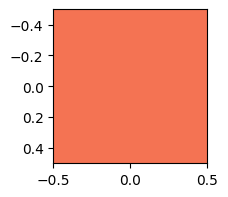

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Forest, R,G,B: 144 139 105


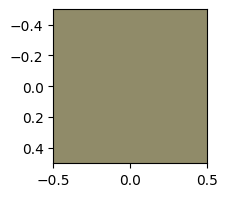

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Keras Red, R,G,B: 212 27 25


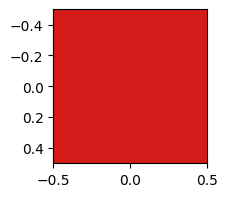

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Cream Bull, R,G,B: 89 97 166


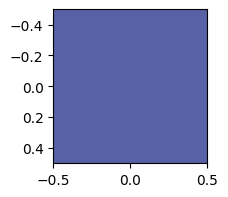

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Evil Google, R,G,B: 189 126 54


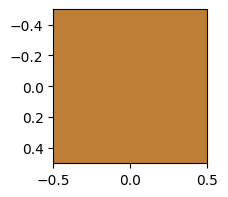

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fantastic Purple, R,G,B: 134 72 126


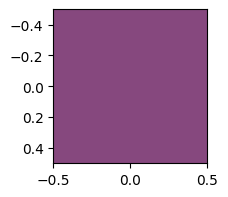

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Misterous John, R,G,B: 192 180 133


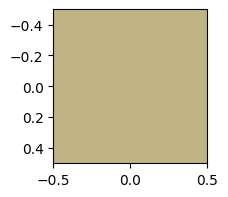

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Misterous Yellow, R,G,B: 237 215 54


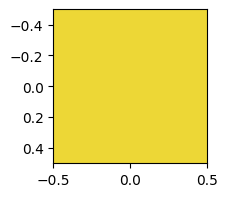

In [ ]:
predict("tensorflow orange")
predict("forest")
predict("keras red")
predict("cream bull")
predict("evil google")
predict("fantastic purple")
predict("misterous john")
predict("misterous yellow")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Aereo, R,G,B: 100 148 106


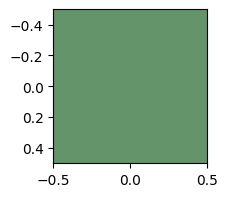

In [ ]:
predict("aereo")